In [1]:
import tarfile
from urllib.request import urlretrieve
import os
import nltk
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Onehot encoding

In one-hot encoding, you represent a word with ones and zeros. More specifically, one item will be one and rest will be zeros. The index of the element having value one is unique for each word. The length of the vector is determined by the size of the vocabulary.

In [19]:
from tensorflow.keras.utils import to_categorical

doc = "the cat sat on the mat"
words = doc.split(" ")
word_id_map = {"the":0, "cat":1, "sat":2, "on": 3, "mat":4}
ids = [word_id_map[w] for w in words]

oh = to_categorical(ids, num_classes=5)
print(oh)


[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


## Bag of words

Bag of words represents a document as a sequence of counts, where each count represents how many times a given word has been present in that document. Note that, the bag of words representation completely disregard the order/flow of words in the document.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.','This is the second second document.',
    'And the third one.','Is this the first document?'
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray())
print(vectorizer.vocabulary_)

[[0 1 1 1 0 0 1 0 1]
 [0 1 0 1 0 2 1 0 1]
 [1 0 0 0 1 0 1 1 0]
 [0 1 1 1 0 0 1 0 1]]
{'this': 8, 'the': 6, 'third': 7, 'one': 4, 'document': 1, 'first': 2, 'is': 3, 'and': 0, 'second': 5}


## TF-IDF Computation

${TF-IDF} = TF \times IDF$


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'This is the first document.','This is the second second document.',
    'And the third one.','Is this the first document?'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray())
print(vectorizer.vocabulary_)

[[0.         0.43877674 0.54197657 0.43877674 0.         0.
  0.35872874 0.         0.43877674]
 [0.         0.27230147 0.         0.27230147 0.         0.85322574
  0.22262429 0.         0.27230147]
 [0.55280532 0.         0.         0.         0.55280532 0.
  0.28847675 0.55280532 0.        ]
 [0.         0.43877674 0.54197657 0.43877674 0.         0.
  0.35872874 0.         0.43877674]]
{'this': 8, 'the': 6, 'third': 7, 'one': 4, 'document': 1, 'first': 2, 'is': 3, 'and': 0, 'second': 5}


## Downloading the data

In order to learn word vectors, we will be using movie reviews data. Here, we are downloading the file and extracting the relevant file.

In [2]:
url = 'http://www.cs.cmu.edu/~ark/personas/data/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists("datasets"):
    os.mkdir("datasets")
  if not os.path.exists(os.path.join("datasets", filename)):
    print('Downloading file...')
    _, _ = urlretrieve(url + filename, os.path.join("datasets",filename))
  else:
    print('File exists ...')

  print("Extracting the file")
  tar = tarfile.open(os.path.join("datasets",filename), "r:gz")
  tar.extractall("datasets")
  tar.close()
    
  statinfo = os.stat(os.path.join("datasets",filename))
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % os.path.join("datasets",filename))
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + os.path.join("datasets",filename) + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('MovieSummaries.tar.gz', 48002242)

File exists ...
Extracting the file
Found and verified datasets\MovieSummaries.tar.gz


## Reading in the data

Reading the rows in the file. Each row contains the synopsis of a movie.

In [3]:
def read_data(filename, n_lines):
    """ Reading the zip file to extract text """
    docs = []
    i = 0
    with open(filename, 'r', encoding='utf-8') as f:
        for row in f:
            file_string = nltk.word_tokenize(row)
            # First token is the movie ID
            docs.append(' '.join(file_string[1:]).lower())
            i += 1
            if n_lines and i == n_lines:
                break
    return docs

docs = read_data(os.path.join("datasets", "MovieSummaries", 'plot_summaries.txt'), 10000)
print("Read in {} documents".format(len(docs)))

Read in 10000 documents


## Exploring the data

Let's print a few samples and see what we got.

In [4]:
for d in docs[:5]:
    print(d,'\n')

shlykov , a hard-working taxi driver and lyosha , a saxophonist , develop a bizarre love-hate relationship , and despite their prejudices , realize they are n't so different after all . 

the nation of panem consists of a wealthy capitol and twelve poorer districts . as punishment for a past rebellion , each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual hunger games . the tributes must fight to the death in an arena ; the sole survivor is rewarded with fame and wealth . in her first reaping , 12-year-old primrose everdeen is chosen from district 12 . her older sister katniss volunteers to take her place . peeta mellark , a baker 's son who once gave katniss bread when she was starving , is the other district 12 tribute . katniss and peeta are taken to the capitol , accompanied by their frequently drunk mentor , past victor haymitch abernathy . he warns them about the `` career '' tributes who train intensively at special academies

## Cleaning up data

The following simple preprocessing steps are done to clean the data.

* Remove any stop words
* Remove any punctuation

In [5]:
from nltk.corpus import stopwords 
stop_words = list(stopwords.words('english')) 
sw_regex = r'(?:' + ' | '.join([sw for sw in stop_words]) + ')'
punct_regex = r'[.,\/#!$%\^&\*;:{}=\-_`~()]'

ser = pd.Series(docs)
# We are doing the stop word regex twice, as otherwise when two stopwords occur together
# they are not replaced (e.g. 'for the')
ser = ser.str.replace(sw_regex, ' ')
ser = ser.str.replace(sw_regex, ' ')
ser = ser.str.replace(punct_regex, ' ')
ser.head()

0    shlykov   hard working tax driver lyosha   sax...
1    the nation panem consists wealthy capitol twel...
2    poovall induchoodan sentenced six years prison...
3    the lemon drop kid   new york city swindler   ...
4    seventh day adventist church pastor michael ch...
dtype: object

## Plotting the frequency of words

Getting the counts of words in our text corpus and plotting the word frequencies.

In [6]:
from collections import Counter

corpus = ser.str.cat(sep=' ').split(' ')
word_count = Counter(corpus).most_common()

words, counts = zip(*word_count)


([<matplotlib.axis.XTick at 0x2323e07eb38>,
 <a list of 50 Text xticklabel objects>)

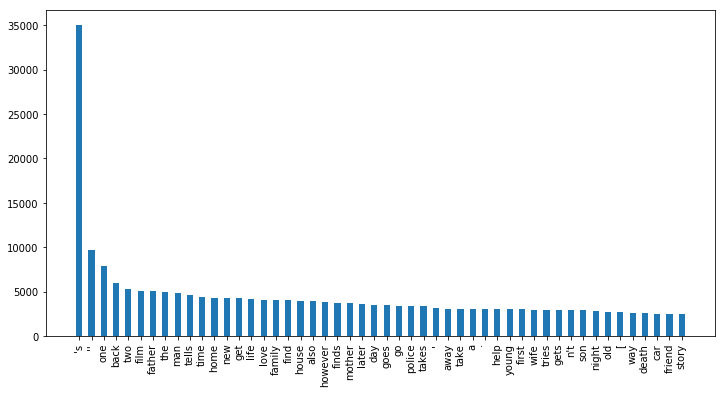

In [7]:
plt.figure(figsize=(12,6))
x = np.arange(50)
plt.bar(x, counts[1:51], width=0.5)
plt.xticks(x, words[1:51], rotation='vertical')

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Defining the tokenizer

Defining a tokenizer to learn the word to index mapping. We will also replace any rare word with `UNK` token.

In [9]:
docs = ser.tolist()
v_size = 3000
# Define a tokenizer num_words v_size and oov_token UNK
tokenizer = ____
# Fit the text 
tokenizer.____(____)

## Computing the co-occurence matrix

Computes the co-occurence matrix and save it to the disk can either load the existing matrix or compute a new one by changing `generate_cooc` variable.

In [10]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            context_window = sequence[i-window_size: i+window_size+1]
            distances = np.abs(np.arange(-window_size, window_size+1))
            distances[window_size] = 1.0
            nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            nom[window_size] = 0.0

            if use_weighting:
                cooc_mat[wi, context_window] += nom/distances    # Update element
            else:
                cooc_mat[wi, context_window] += nom
    
    return cooc_mat    

if generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, True)
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))

Cooc matrix of type lil_matrix was loaded from disk


## Validating the co-occurrence matrix
Taking a specific word and plotting the frequencies of the most common 25 co-occurinng words. Making sure that the word distribution makes sense (Zif's law) and the co-occuring words are valid (visually)

([<matplotlib.axis.XTick at 0x2324c8a9c50>,
 <a list of 25 Text xticklabel objects>)

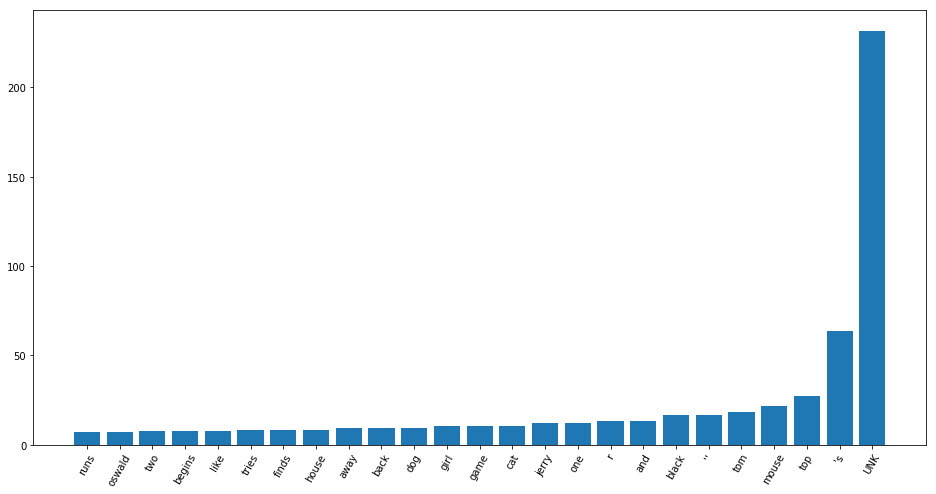

In [11]:
word = 'cat'
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
max_ind = np.argsort(cooc_vec)[-25:]
#print(max_ind)
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

## Defining GloVe model with Keras

In order to define the GloVe model, a custom loss function is required. However, GloVe loss essentially boils down to a mean square error, which makes it easier to define as a custom loss function. Let's have a quick look. GloVe loss is defined as,

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_i^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

where $X_{ij}$ is the $i,j$ cell of the co-occurence matrix and $w,\tilde{w},b,\tilde{b}$ are weights and biases. For a full explanation refer the [original paper](https://nlp.stanford.edu/pubs/glove.pdf). When you play around with parenthesis you will start seeing the squared loss.

$J = \sum_{i,j=1}^{V} f(X_{ij})\{(w_i^T\tilde{w}_j + b_i + \tilde{b}_j) - log(X_{ij})\}^2$, 

which is like,

$J = \sum A ( B - C)^2$


In [30]:
def create_glove_model(v_size):
    
    # Define w_i; an Input layer which has size [None] (with batch dimension)
    w_i = ____
    # Define w_j; an Input layer which has size [None] (with batch dimension)
    w_j = ____
    
    # Embedding layers for words i and j
    # Get the output of an Embedding layer (96 dimensions)
    emb_i = ____(____)
    emb_j = ____(____)

    # Create the dot product of above two inputs
    ij_dot = Dot(axes=-1)(____)
    
    # Bias embedding layers wor words i and j
    # Get b_i and b_j using two Embedding layers with size 1
    b_i = ____(____)
    b_j = ____(____)

    pred = Add()([____, ____, ____])

    def glove_loss(y_true, y_pred):
        """ Defining the GloVe loss """
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[____, ____],outputs=____)
    # Compiling the model with the defined loss and an optimizer
    model.compile(loss=____, optimizer =Adam(lr=0.0001))
    return model


## Clearning session and analysing the model

In [31]:
K.clear_session()

model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 96)           288000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 96)           288000      input_2[0][0]                    
______________________________________________________________________________________________

## Run and eval Glove

Here, we are doing the following.

For each epoch,

* Shuffle the data
* Generate a batch of skip-gram word pairs
* Perform `model.fit()`
* Evaluate the loss

In [35]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =128
copy_docs = list(docs[:2000])
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1), np.array(sg_out).reshape(-1)
        x_ij = cooc_mat[sg_in, sg_out].reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        
        
        # Define correct inputs and outputs for model.fit() and model.evaluate()
        model.fit([____, ____], ____, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate(____, ____, batch_size=batch_size, verbose=0)
        
        
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))


Loss in epoch 0: 33941.88187703899
Loss in epoch 1: 14.157527599161725
Loss in epoch 2: 6.717716845648533
Loss in epoch 3: 3.9831158131665534
Loss in epoch 4: 2.76027855365505
Loss in epoch 5: 2.113772107243788
Loss in epoch 6: 1.7043591649574628
Loss in epoch 7: 1.4062234117514978
Loss in epoch 8: 1.190997126159213
Loss in epoch 9: 1.0219524332704397


## Understanding how skipgrams work

## Saving the model and the embeddings to the disk

In [15]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

## Printing out some similar words of a set of valid words

In [16]:
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(100)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        

valid_words = get_valid_words(docs, 100, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w.csv'))
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))

Loading the word embeddings from the disk
Embedding shape: (3000, 96)
UNK: pedro, franklin, andrea, giovann, mitch
returns: home, finds, gone, returning, return
husband: wife, her, mistress, mary, son
falls: fell, instantly, deeply, express, asleep
UNK: pedro, franklin, andrea, giovann, mitch
race: horse, human, drawn, remove, match
along: way, makes, make, appearance, came
women: men, lovers, two, sons, sisters
estranged: logan, deceased, avenge, adopted, her
former: lover, girlfriend, lawyer, al, partner
pursue: career, hires, teaches, research, beneath
story: flashback, based, told, follows, begins
london: england, turned, transforms, pulled, bringing
UNK: pedro, franklin, andrea, giovann, mitch
heart: suffers, attack, broken, change, suffered
UNK: pedro, franklin, andrea, giovann, mitch
UNK: pedro, franklin, andrea, giovann, mitch
woman: named, man, beautiful, blonde, attractive
UNK: pedro, franklin, andrea, giovann, mitch
UNK: pedro, franklin, andrea, giovann, mitch
room: hotel, e

c:\anaconda3\envs\tekbac.nlp\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
